### Data Loader

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import os
import re

In [2]:
# Setup path to data folder
data_path = Path("/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/")
image_path = data_path / "brightfield"

In [3]:
image_dir = '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well2_200locations'
mask_dir = '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/masks'

In [4]:
random.seed(42)
image_path_list = list(image_path.glob("*/*.tif")) # * means "any combination"
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

Random image path: /zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well2_200locations/Alexa488_Fibroblasts_well2_200locations_s088z02c2_ORG.tif
Image class: Alexa488_Fibroblasts_well2_200locations
Image height: 1024
Image width: 1024


In [5]:
class RandomFlipAndScale(object):

    def __call__(self, image):

    # def __call__(self, image, mask):

        # Randomly flip horizontally or vertically

        if torch.rand(1) > 0.5:

            image = torch.flip(image, dims=[2])  # Horizontal flip

            # mask = torch.flip(mask, dims=[2])

        else:

            image = torch.flip(image, dims=[3])  # Vertical flip

            # mask = torch.flip(mask, dims=[3])



        # Random scaling

        scale = torch.rand(1) * 0.2 + 0.9  # Scale factor between 0.9 and 1.1

        image = torch.nn.functional.interpolate(image, scale_factor=scale, mode='nearest')

        # mask = torch.nn.functional.interpolate(mask, scale_factor=scale, mode='nearest')



        return image #, mask



class RandomRotationAndContrast(object):

    def __call__(self, image):

    # def __call__(self, image, mask):

        # Random rotation

        angle = torch.randint(-60, 61, (1,))

        image = torch.rot90(image, angle, dims=[1, 2])

        # mask = torch.rot90(mask, angle, dims=[1, 2])



        # Contrast adjustment

        contrast_factor = torch.rand(1) * 0.5 + 0.8  # Factor between 0.8 and 1.3

        image = image * contrast_factor



        return image #, mask





class ShearAndNoise(object):

    def __call__(self, image):

    # def __call__(self, image, mask):

        # Shearing

        shear_factor = torch.rand(1) * 0.2 - 0.1  # Shear factor between -0.1 and 0.1

        theta = torch.tensor([[1, shear_factor], [0, 1]])

        grid = torch.nn.functional.affine_grid(theta.unsqueeze(0), image.size())

        image = torch.nn.functional.grid_sample(image.unsqueeze(0), grid, mode='bilinear', padding_mode='border').squeeze(0)

        # mask = torch.nn.functional.grid_sample(mask.unsqueeze(0), grid, mode='nearest', padding_mode='border').squeeze(0)



        # Gaussian noise

        noise = torch.randn_like(image) * 0.05  # Adjust noise level as needed

        image = image + noise



        return image #, mask

SyntaxError: invalid non-printable character U+00A0 (2167044988.py, line 3)

In [7]:
class RandomFlipAndScale(object):
    def __call__(self, image):
    # def __call__(self, image, mask):

        image = transforms.ToTensor()(image)
        
        # Randomly flip horizontally or vertically
        if torch.rand(1) > 0.5:
            image = torch.flip(image, dims=[1])  # Horizontal flip
            # mask = torch.flip(mask, dims=[2])
        else:
            image = torch.flip(image, dims=[2])  # Vertical flip
            # mask = torch.flip(mask, dims=[3])

        # Random scaling
        scale = torch.rand(1) * 0.2 + 0.9  # Scale factor between 0.9 and 1.1
        image = torch.nn.functional.interpolate(image, scale_factor=0.9, mode='nearest')
        # mask = torch.nn.functional.interpolate(mask, scale_factor=scale, mode='nearest')
        #image = transforms.ToPILImage()(image)
        return image #, mask

class RandomRotationAndContrast(object):
    def __call__(self, image):
    # def __call__(self, image, mask):

        image = transforms.ToTensor()(image)
        
        # Random rotation
        angle = torch.randint(-60, 61, (1,))
        angle = angle.item()  # Convert tensor to integer
        image = torch.rot90(image, 40, dims=[1, 2])
        # mask = torch.rot90(mask, angle, dims=[1, 2])

        # Contrast adjustment
        contrast_factor = torch.rand(1) * 0.5 + 0.8  # Factor between 0.8 and 1.3
        image = image * contrast_factor
        #image = transforms.ToPILImage()(image)
        return image #, mask


class ShearAndNoise(object):
    def __call__(self, image):
    # def __call__(self, image, mask):

        image = transforms.ToTensor()(image)
        
        # Add a batch dimension
        image = image.unsqueeze(0)

        # Shearing
        shear_factor = torch.rand(1) * 0.2 - 0.1  # Shear factor between -0.1 and 0.1
        theta = torch.tensor([[1, shear_factor], [0, 1]])
        # Reshape theta to [1, 2, 3]
        theta = theta.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

        grid = torch.nn.functional.affine_grid(theta, image.size())
        image = torch.nn.functional.grid_sample(image, grid, mode='bilinear', padding_mode='border').squeeze(0)

        # Remove the batch dimension
        image = image.squeeze(0)

        # Gaussian noise
        noise = torch.randn_like(image) * 0.05  # Adjust noise level as needed
        image = image + noise
        #image = transforms.ToPILImage()(image)
        return image #, mask

In [8]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
mask_transform = data_transform

In [9]:
transform1 = transforms.Compose([RandomFlipAndScale()])
transform2 = transforms.Compose([RandomRotationAndContrast()])
transform3 = transforms.Compose([ShearAndNoise()])

f <class 'PIL.TiffImagePlugin.TiffImageFile'>
image <class 'torch.Tensor'>
f <class 'PIL.TiffImagePlugin.TiffImageFile'>
image <class 'torch.Tensor'>
f <class 'PIL.TiffImagePlugin.TiffImageFile'>
image <class 'torch.Tensor'>
Test image


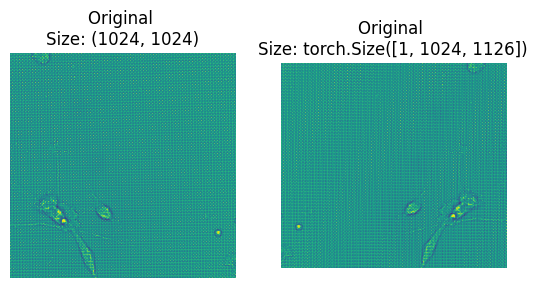

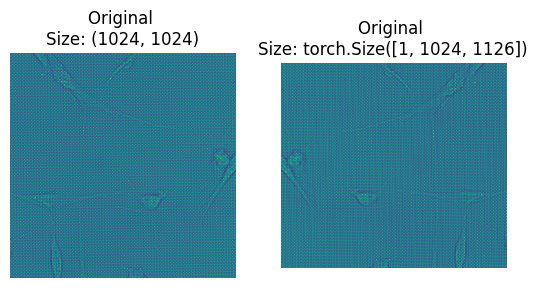

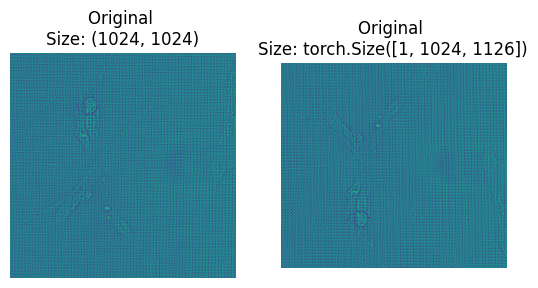

In [10]:
def plot_transformed_images(image_paths, transform1, transform2, transform3, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image1 = transform1(f).permute(1, 2, 0) 

            image = transforms.ToTensor()(f)
            # Randomly flip horizontally or vertically
            if torch.rand(1) > 0.5:
                image = torch.flip(image, dims=[1])  # Horizontal flip
                # mask = torch.flip(mask, dims=[2])
            else:
                image = torch.flip(image, dims=[2])  # Vertical flip
                # mask = torch.flip(mask, dims=[3])
    
            # Random scaling
            scale = torch.rand(1) * 0.2 + 0.9  # Scale factor between 0.9 and 1.1
            image = torch.nn.functional.interpolate(image, scale_factor=1.1, mode='nearest')
            
            print("f", type(f))
            print("image",type(image))
            ax[1].imshow(image.permute(1, 2, 0) ) 
            ax[1].set_title(f"Original \nSize: {image.shape}")
            ax[1].axis("off")
            

plot_transformed_images(image_path_list, 
                        transform1=transform1, 
                        transform2=transform2,
                        transform3=transform3,
                        n=3)
print("Test image")

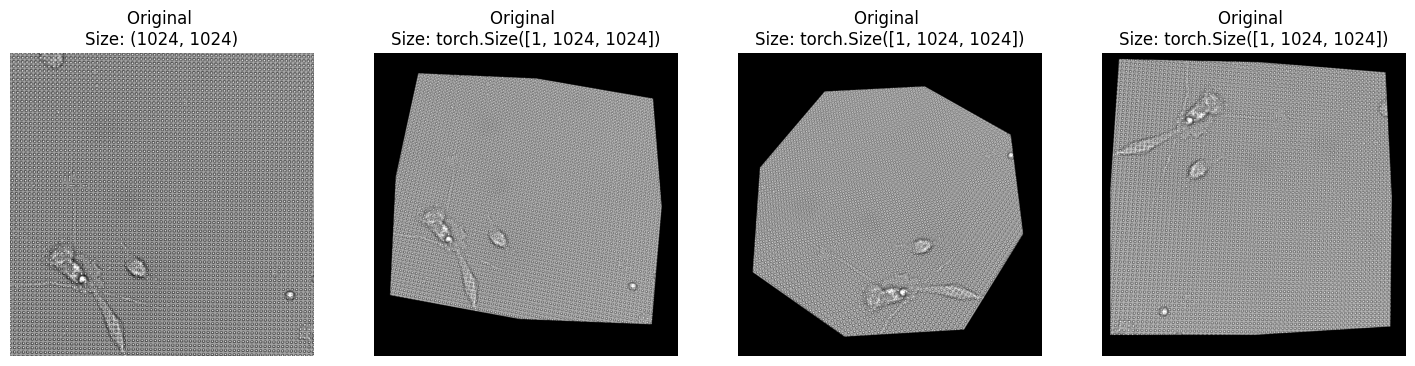

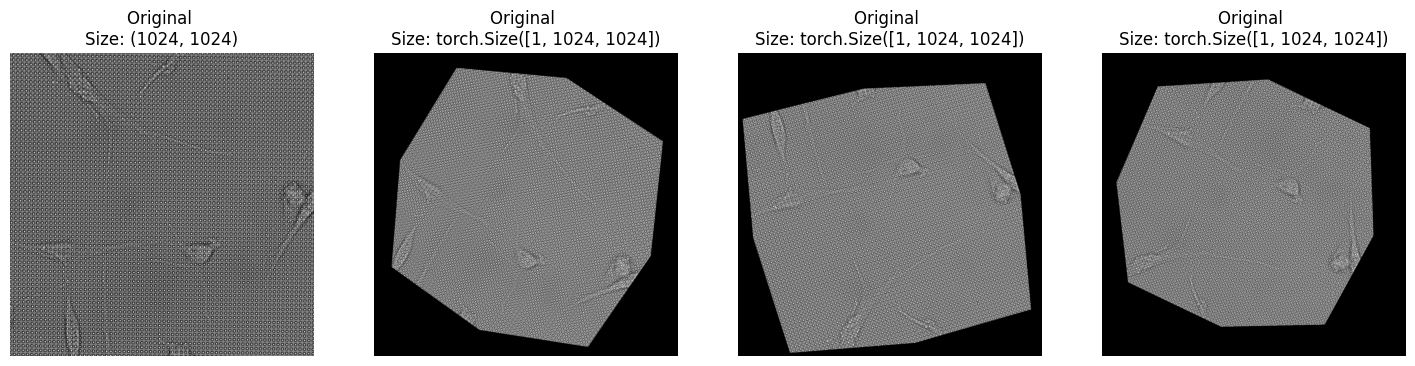

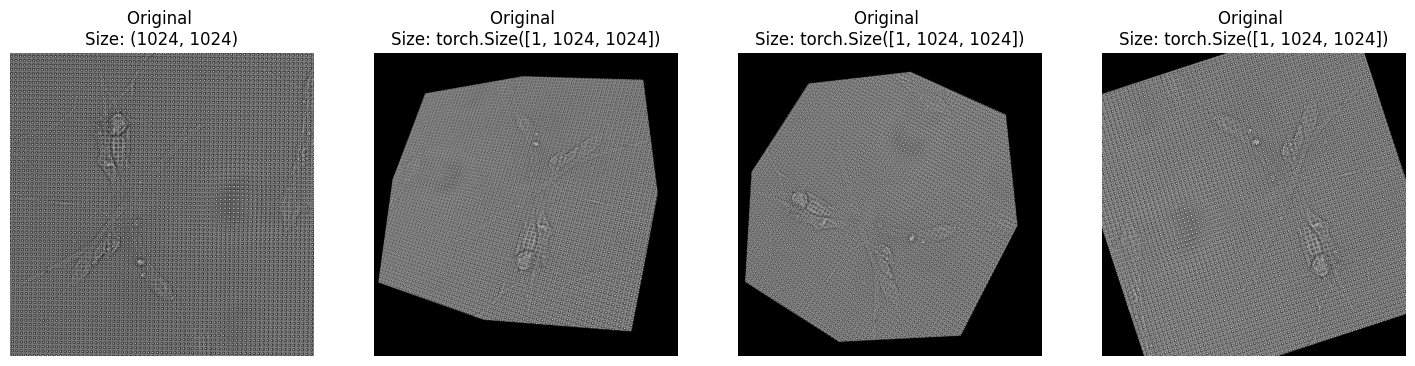

In [35]:
def plot_transformed_images_STAR(image_paths, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 4, figsize = (18,6))
            ax[0].imshow(f, cmap='grey') 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            
            # convert image to tensor For transforms.v2 method
            image = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(f)
            
                     
            transform1 = transforms.Compose([
                                            transforms.RandomHorizontalFlip(p=0.75),
                                            transforms.RandomVerticalFlip(p=0.75),
                                            transforms.RandomRotation(degrees=(-180, 180)),                                            
                                            ])
            transform2 = transforms.Compose([
                                            transforms.RandomHorizontalFlip(p=0.75),
                                            transforms.RandomVerticalFlip(p=0.75),
                                            transforms.RandomPerspective(distortion_scale= 0.25, p = 0.8)
                                            ])
            

            image1_trans = transform1(image)
            image2_trans = transform2(image)
            image3_trans = transform1(image)

            
            ax[1].imshow(image1_trans.permute(1, 2, 0), cmap='grey' ) 
            ax[1].set_title(f"Original \nSize: {image1_trans.shape}")
            ax[1].axis("off")

            ax[2].imshow(image2_trans.permute(1, 2, 0), cmap='grey' ) 
            ax[2].set_title(f"Original \nSize: {image2_trans.shape}")
            ax[2].axis("off")

            ax[3].imshow(image3_trans.permute(1, 2, 0), cmap='grey' ) 
            ax[3].set_title(f"Original \nSize: {image3_trans.shape}")
            ax[3].axis("off")
            

plot_transformed_images_STAR(image_path_list, n=3)


In [ ]:
# Example usage
image, mask = ...  # Your original image and mask tensors
augmented_image, augmented_mask = transform(image, mask)